In [34]:
!pip install opencv-python

!pip install scikit-image


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 6.1 MB/s eta 0:00:000:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.5 MB/s eta 0:00:007.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 7.6 MB/s eta 0:00:007.8 MB/s eta 0:00:01


In [62]:
import pandas as pd 
import os 
import cv2
import time
from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import math
import numpy as np
from skimage import transform

En primer lugar se toma los datos y se realiza una union para el dataset de Anti-Spoofing Dataset, 30,000 sets

In [123]:
def obtener_imagenes_video(video_path):    
    cap = cv2.VideoCapture(video_path)
    
    # Obtener información del video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    
    # Capturar imágenes
    times = [0, duration / 2, duration - 1]
    for t in times:
        cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000)
        ret, frame = cap.read()
        if ret:
            timestamp = int(time.time())
            cv2.imwrite(f'./data/output_{timestamp}_{int(t)}.jpg', frame)
    
    cap.release()

def preprocess_image(img, target_size=(1000, 1000)):
    """Redimensiona la imagen a un tamaño fijo y convierte a uint8."""
    img_resized = transform.resize(img, target_size)
    return (img_resized * 255).astype(np.uint8)



def cargar_imagenes_carpeta(carpeta):
    images = []
    features = []
    filenames = [] 

    for filename in os.listdir(carpeta):
        img = cv2.imread(os.path.join(carpeta, filename))
        if img is not None:
            height, width, _ = img.shape            
            img_resized = preprocess_image(img)  
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
            # Aplicar Sobel
            img_sobel = cv2.Sobel(img_gray, cv2.CV_8U, 1, 1, ksize=3)
    
            # Aplicar Canny
            img_canny = cv2.Canny(img_gray, 50, 150)
    
            # Puedes combinar ambos resultados, Sobel y Canny
            img_combined = cv2.addWeighted(img_sobel, 0.5, img_canny, 0.5, 0)
    
            # Extraer características HOG de la imagen combinada
            hog_features, hog_image = hog(img_combined, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
            hog_image = exposure.rescale_intensity(hog_image, out_range=(0, 1))
    
            # Almacenar los resultados
            features.append(hog_features)
            images.append(hog_image)
            filenames.append(filename)


    return np.array(images), np.array(features), filenames

como el dataset tiene videos estos se colocan en la carpeta dataset1 para despues usar la funcion de obtener imagenes la cual extrae 3 fotografias al inicio, en el medio y al final de los videos


In [95]:
path_videos_dataset1 = './data/dataset1'
videos_dataset1 = os.listdir(path_videos_dataset1)
videos_dataset1

['0001ffba3c--62960f430bd50b2755f74916__Galaxy M31__M2003J15SG.mp4',
 'cut-0001e96803--62663cf6d21d14509973bcb4.mp4',
 '0001e96803--6239cf6720237d576aafbe45.mp4',
 '0001ffba3c--6289196875a5cf63cd0cb302__Samsung galaxy s20 __IPhone 6s plus.mp4',
 '0001e96803--6239cf6720237d576aafbe45__Samsung Galaxy a22.mp4',
 'cut-0001e96803--623955e76e1ee5175569a12b.mp4',
 '0001e96803--623955e76e1ee5175569a12b.mp4',
 '0001ffba3c--6295ba1f8753764e91dcf5df__Poco X3 Pro__Tecno Pouvoir 4.mp4',
 'cut-0001e96803--62294efac72a824e5bb369f3.mp4',
 'cut-0001e96803--62457bc94ff454214e8af551.mp4',
 'cut-0001e96803--624508e961974a65884d9fd3.mp4',
 '0001ffba3c--628c9dbb2579312f1ac7ee6f__-  20__- 22.mp4',
 '0001ffba3c--629066494796d7421dad66b7__iPhone xr __iPhone 6s.MOV',
 '0001e96803--62457bc94ff454214e8af551__Infinix note 11.mp4',
 'cut-0001e96803--6228928cb608822f9f53589e.mp4',
 '0001e96803--6228928cb608822f9f53589e__Xiaomi redmi note 9 pro.mp4',
 '0001ffba3c--628e621c6789b1401e3cb184__Honor 50__Samsung note 9.mp

In [26]:
for videos in videos_dataset1:
    obtener_imagenes_video(f'{path_videos_dataset1}/{videos}')

se realiza un analisis de clustering para la persona 1

In [124]:
persona1_hog_images, persona1_features, persona1_filenames = cargar_imagenes_carpeta('./data/persona 1')

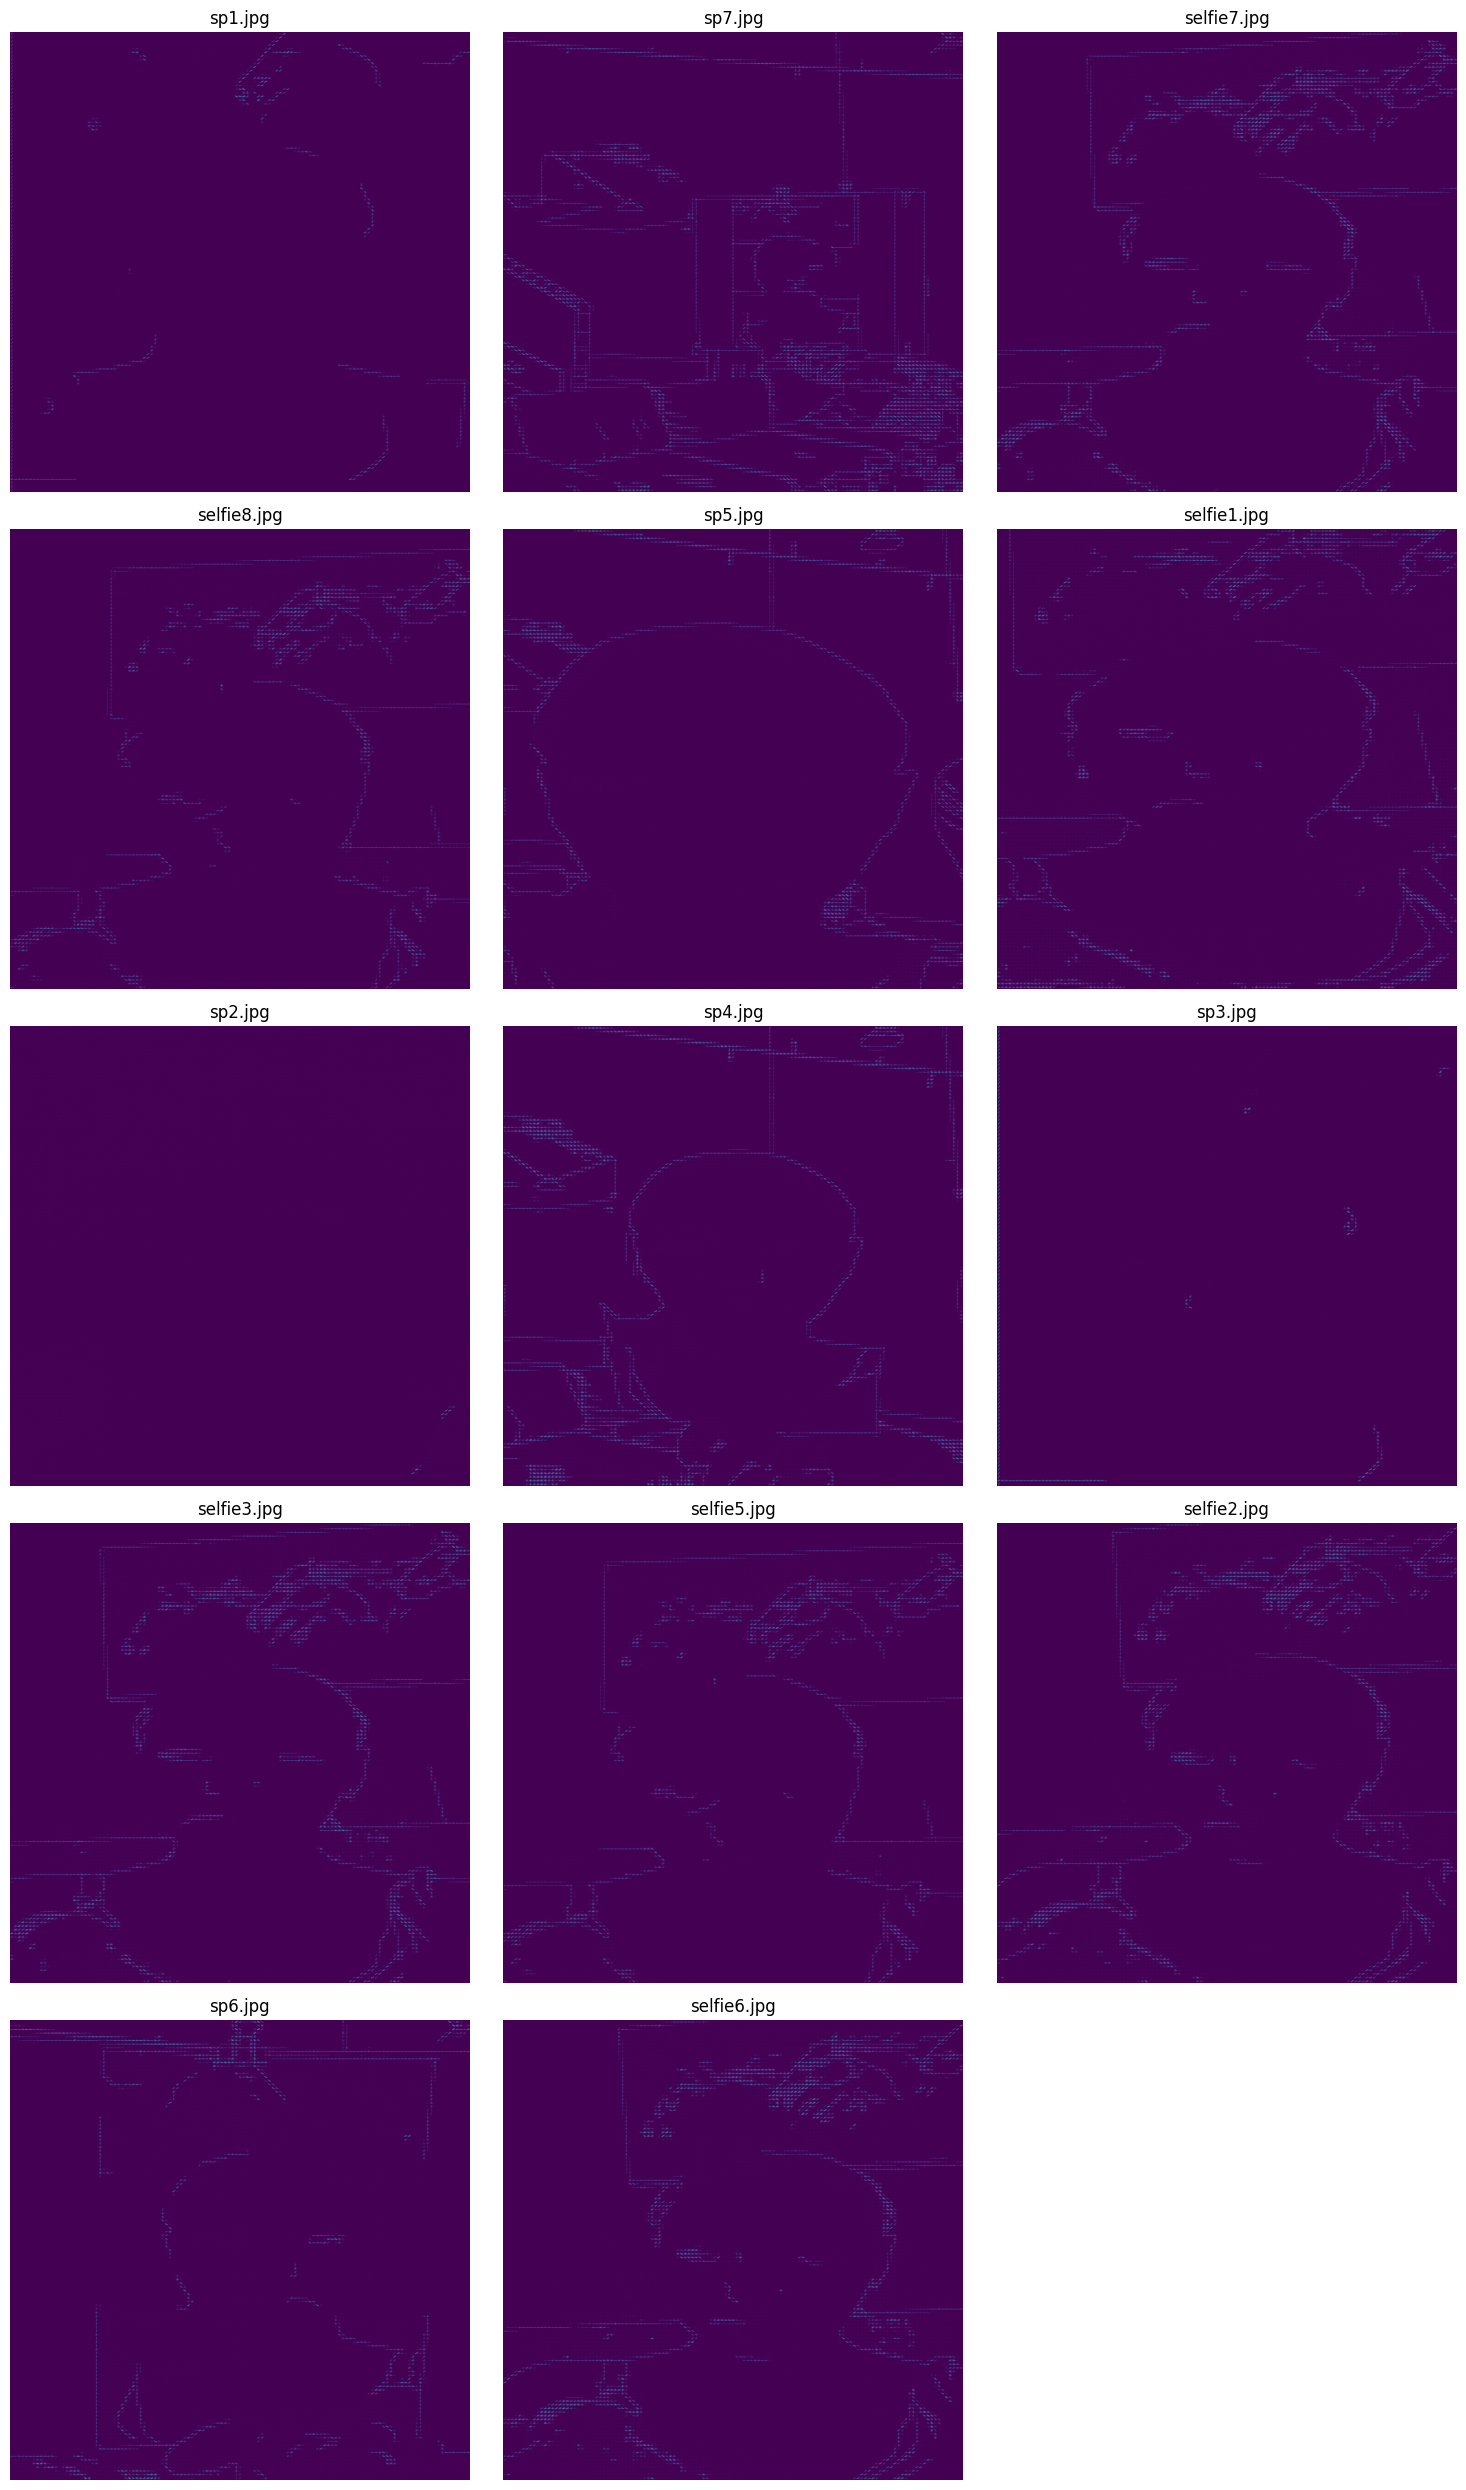

In [125]:


max_images = len(persona1_hog_images)  # Total de imágenes
num_images = min(len(persona1_hog_images), max_images)

# Calcular filas y columnas
cols = 3  # Número de columnas
rows = math.ceil(num_images / cols)  # Número de filas

# Graficar las imágenes HOG junto con sus nombres
plt.figure(figsize=(15, 5 * rows))  # Ajustar el tamaño según el número de filas
for i in range(num_images):
    plt.subplot(rows, cols, i + 1) 
    plt.imshow(persona1_hog_images[i])  # Mostrar la imagen HOG en escala de grises
    plt.title(persona1_filenames[i])  # Imprimir el nombre de la imagen
    plt.axis('off')
plt.tight_layout()
plt.show()


se  pre procesa los datos usando hog para capturar las caracteristicas de textura ya que para este caso el spoofing se intenta lograr usando el video en un celular o una fotografia recortada o una fotografia normal

In [149]:
persona1_features = np.array(persona1_features)
kmeans_5 = KMeans(n_clusters = 3, random_state = 123, n_init=10).fit_predict(persona1_features)

Etiquetas asignadas por KMeans:
sp1.jpg: 1
sp7.jpg: 1
selfie7.jpg: 0
selfie8.jpg: 2
sp5.jpg: 1
selfie1.jpg: 1
sp2.jpg: 1
sp4.jpg: 1
sp3.jpg: 1
selfie3.jpg: 0
selfie5.jpg: 2
selfie2.jpg: 1
sp6.jpg: 1
selfie6.jpg: 1


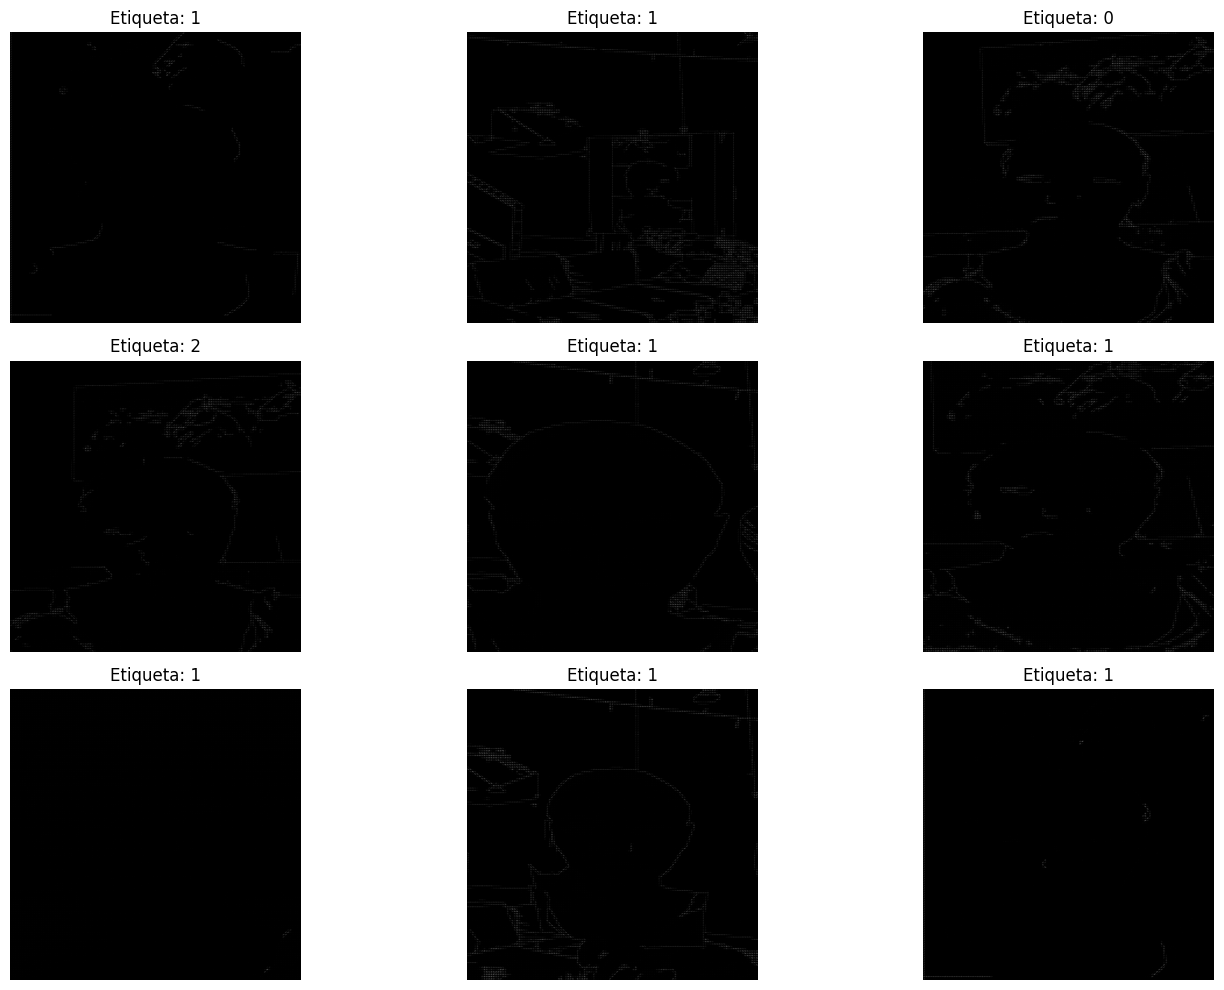

In [150]:
import matplotlib.pyplot as plt

# Suponiendo que `persona1_hog_images` y `persona1_filenames` están disponibles
# Imprimir las etiquetas
print("Etiquetas asignadas por KMeans:")
for filename, label in zip(persona1_filenames, kmeans_5):
    print(f"{filename}: {label}")

# Graficar algunas imágenes con sus etiquetas
num_images = min(len(persona1_hog_images), 9)  # Muestra hasta 9 imágenes
plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(persona1_hog_images[i], cmap='gray')  # Mostrar la imagen HOG
    plt.title(f"Etiqueta: {kmeans_5[i]}")  # Mostrar la etiqueta asignada
    plt.axis('off')
plt.tight_layout()
plt.show()


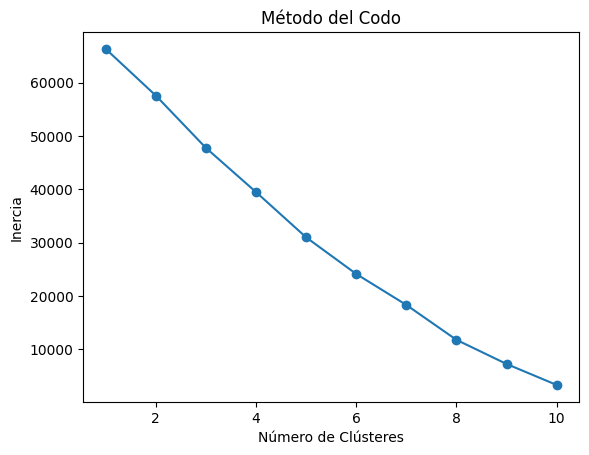

In [151]:

def calcular_inercia(features, max_clusters=10):
    inercia = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)
        kmeans.fit(features)
        inercia.append(kmeans.inertia_)
    return inercia

# Calcular la inercia para varios valores de n_clusters
inercia = calcular_inercia(persona1_features, max_clusters=10)

# Graficar el método del codo
plt.plot(range(1, 11), inercia, marker='o')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()
